# (w/input) Hands-on AgTech - Visão Computacional

Reconhecimento de objetos com dataset CIFAR-10 e visão computacional, agora recebendo e tratando arquivos de dados vindos do usuário.

## Declaração de parâmetros e hiperparâmetros

Declare parâmetros com o botão  na barra de ferramentas.<br>
A variável `dataset` possui o caminho para leitura do arquivos importados na tarefa de "Upload de dados".<br>
Você também pode importar arquivos com o botão  na barra de ferramentas.

In [7]:
dataset = "/tmp/data/CIFAR10_subset-2.zip" #@param {type:"string"}

batch_size = 2 #@param {type:"integer", description:"Tamanho de batch utilizado em cada passo do treinamento do modelo"}
num_classes = 10 #@param {type:"integer", description:"Número de classes na base da dados"}
num_epochs = 15 #@param {type:"integer", description:"Número de épocas para treinar modelo"}

In [5]:
import time
import numpy as np
import os
import cv2
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical

plt.rcParams["figure.figsize"] = (15,10)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


## Leitura do conjunto de dados

Nessa tarefa simples de classificação de imagens iremos utilizar a base de dados CIFAR-10.

Essa base possui 10 classes e cada amostra é uma imagens de dimensão (32, 32, 3)

Como o dataset está compactado, precisamos descompactar tudo para poder ler as imagens e enviá-las como entrada para o modelo:

In [8]:
root_folder_name = dataset.split("/")[-1].split(".")[0]
print
root_folder = os.path.join("/tmp/data", root_folder_name)
with zipfile.ZipFile(dataset, 'r') as zip_ref:
    zip_ref.extractall(root_folder)

Em geral, não é possível carregar todo o conjunto da dados quando nosso dataset é composto por imagens.
Isso ocorre porque esses dados são mais pesados e o todos eles não cabem ao mesmo tempo na memória da maioria das máquinas.
Dessa forma, precisamos de uma forma de carregar, em tempo de treinamento dos modelos, o batch de imagens que necessitamos
naquele momento. 

In [21]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(root_folder, 'train'),
    labels='inferred', label_mode='categorical',
    image_size=(32, 32),
    batch_size=batch_size)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(root_folder, 'val'),
    image_size=(32, 32),
    labels='inferred', label_mode='categorical',
    batch_size=batch_size)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(root_folder, 'test'),
    image_size=(32, 32),
    labels='inferred', label_mode='categorical',
    batch_size=batch_size)

print(train_data.class_names)

Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 149 files belonging to 10 classes.
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Funções de callback 
Callbacks são funções chamadas durante o processo de treinamento 
que realizam ações de forma automática de acordo com a forma
como as inicializamos.

Nessa tarefa utilizaremos:
- ModelCheckpoint: salva os pesos do melhor modelo obtido durante o processo de treinamento


In [10]:
checkpoint_filepath = os.path.join('/tmp/data/', 'epoch-{epoch:02d}-val_loss-{val_loss:.2f}.h5') 
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, 
                                                         monitor='val_loss', 
                                                         save_weights_only=False,
                                                         save_best_only=True,
                                                         mode='min')
callbacks = [checkpoint_callback]

In [11]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

## Construção do modelo de classificação

Nessa etapa iremos utilizar o modelo pré-treinado na base de dados ImageNet.
Para isso, precisamos carregar o modelo da nossa rede (VGG19), alterando
as camadas finais da rede para o nosso formato de saída (10 classes).

In [61]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.applications import VGG19

def build_model(num_classes):
    """Contrutor do modelo"""
    
    # Base da VGG19. Usaremos os pesos pré-treinados na imagenet.
    base_model = VGG19(include_top = False,
                       weights = 'imagenet',
                       input_shape = (32, 32, 3),
                       classes = 10)

    model = Sequential()
    model.add(base_model)
    # Como o output da última camada do base_model é uma matrix,
    # precisamos utilizar a função Flatten para transformá-la em um vetor de forma Nx1 
    # para a entrada das camadas Dense (fully connected)
    model.add(layers.Flatten())
    # Dense layers
    model.add(layers.Dense(1024, activation=('relu'),input_dim=512)) 
    model.add(layers.Dense(512, activation=('relu'))) 
    model.add(layers.Dense(256, activation=('relu'))) 
    model.add(layers.Dense(128, activation=('relu')))
    # Camada de classificação
    model.add(layers.Dense(num_classes, activation=('softmax')))
    # Otimizador de descida do gradiante utilizando momentum
    optimizer = tf.keras.optimizers.SGD(lr = .001, momentum = .9, nesterov = False)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    print(model.summary())
    
    return model

## Treinamento do modelo 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_11 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_13 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_14 (Dense)             (None, 10)               

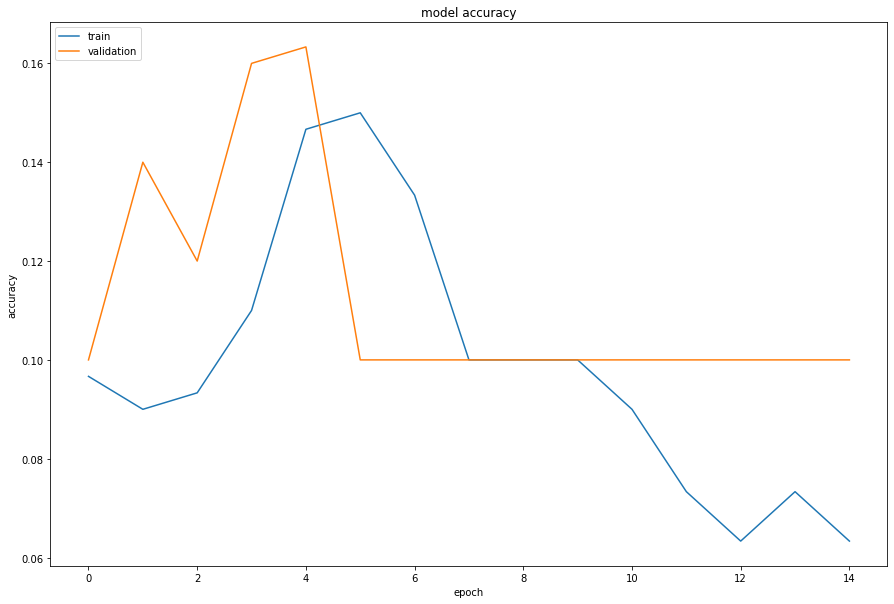

In [22]:
start = time.time()
model = build_model(num_classes)
history = model.fit(train_data, validation_data=val_data,
                    epochs = num_epochs, callbacks = callbacks)
time_elapsed = time.time() - start
print("Training time: {:.03f} min".format(time_elapsed/60))
plot_hist(history)

## Testando modelo

Agora podemos testar nosso modelo utilizando o conjunto de teste composto por amostras nunca antes vistas pelo modelo até então

In [23]:
predictions = model.predict(test_data, verbose = True)

75/75 [==============================] - 21s 283ms/step


In [57]:
y_true = []
for x,y in test_data:
    y_true.append(np.argmax(y[0]))
    if y.shape == (2,10):
        y_true.append(np.argmax(y[1]))
y_true=np.asarray(y_true)

In [58]:
y_pred = np.argmax(predictions, axis=1)
confusion_mtx=confusion_matrix(y_true, y_pred)

(149,)
(149,)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


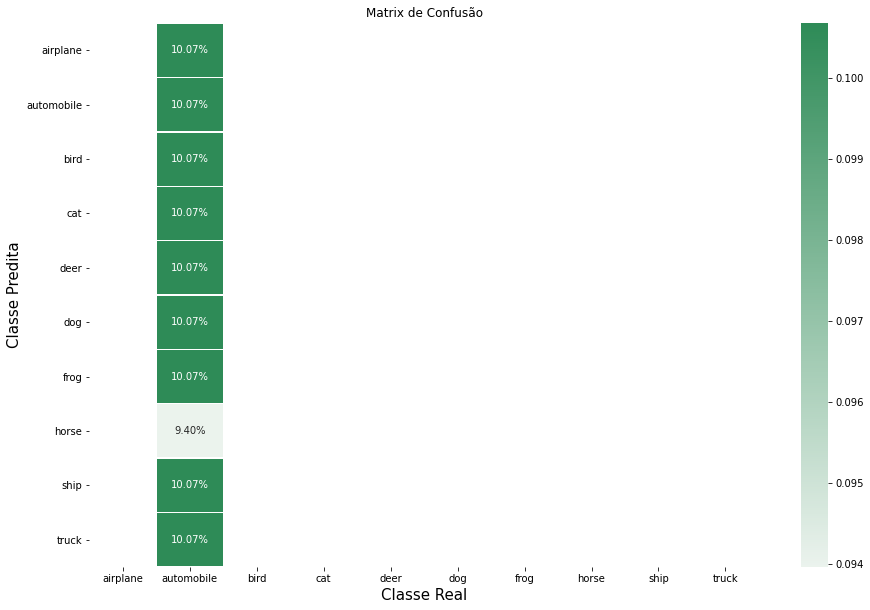

In [59]:
ticklabels = load_label_names()

ax = plt.axes()

sns.heatmap((confusion_mtx/sum(confusion_mtx)), annot=True,
            xticklabels=ticklabels, yticklabels=ticklabels,
            fmt='.02%', cmap=sns.light_palette("seagreen", as_cmap=True),
            linewidths=0.2, ax = ax)

ax.set_title('Matrix de Confusão')
plt.xlabel('Classe Predita', fontsize = 15)
plt.ylabel('Classe Real', fontsize = 15)

plt.show()

## Salva resultados da tarefa

A plataforma guarda o conteúdo de `/tmp/data/` para as tarefas subsequentes.<br>
Use essa pasta para salvar modelos, metadados e outros resultados.

In [60]:
from joblib import dump
from os import listdir
from os.path import isfile, join

class_names = load_label_names()

model_path = "/tmp/data"
checkpoints = [f for f in listdir(model_path) if isfile(join(model_path, f)) and f.startswith("epoch")]
checkpoint_filepath = sorted(checkpoints, reverse=True)[0]

artifacts = {
    "model_path": join(model_path, checkpoint_filepath),
    "class_names": class_names
}
dump(artifacts, "/tmp/data/model.joblib")

['/tmp/data/model.joblib']